# Chọn feature bằng thuật toán tự động
- Chọn sơ bộ feature
- Phân tích và chọn tự động

In [1]:
import math 
import pandas as pd
import numpy as np
from collections import Counter
import joblib

import scipy.stats as ss
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, recall_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import seaborn as sns
from matplotlib import pyplot as plt

import sys
import os.path as path
lib_path =  path.abspath(path.join('' ,"../../api/common"))
sys.path.insert(1, lib_path)
from transform_split_data import transform_split_data
from predict import predict

%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

time: 110 ms


## 1. Load data
- Dữ liệu từ pre_process_data.csv

In [2]:
# Load dữ liệu
df = pd.read_csv('..\\pre_process_data\\pre_process_data.csv')
data_df = df.copy()
data_df

,id$Year,id$MonthDay,id$JyoCD,id$Kaiji,id$Nichiji,id$RaceNum,race_id,Year,Month,RaceInfo$TokuNum,...,KS_SikakuCD,KS_MinaraiCD,KS_TozaiCD,KS_Syotai,KS_ChokyosiCode,CH_SexCD,CH_TozaiCD,CH_Syotai,top3,speed
0,2008,105,6,1,1,1,1,2008,1,0,...,2.0,0.0,1.0,,0.0,1,1,,0,57.446809
1,2008,105,6,1,1,1,1,2008,1,0,...,1.0,0.0,1.0,,0.0,1,1,,1,58.496953
2,2008,105,6,1,1,1,1,2008,1,0,...,2.0,0.0,1.0,,0.0,1,1,,1,58.221024
3,2008,105,6,1,1,1,1,2008,1,0,...,2.0,0.0,1.0,,0.0,1,1,,0,57.676903
4,2008,105,6,1,1,1,1,2008,1,0,...,2.0,0.0,1.0,,0.0,1,1,,1,58.457375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494336,2018,520,8,3,10,12,35925,2018,5,0,...,2.0,0.0,2.0,,0.0,1,2,,1,58.378378
494337,2018,520,8,3,10,12,35925,2018,5,0,...,2.0,0.0,2.0,,0.0,1,2,,0,57.857143
494338,2018,520,8,3,10,12,35925,2018,5,0,...,1.0,3.0,2.0,,1009.0,1,2,,0,57.754011
494339,2018,520,8,3,10,12,35925,2018,5,0,...,1.0,0.0,2.0,,411.0,1,2,,0,57.497782


time: 4.58 s


- Chọn sơ bộ các cột 

In [3]:
id_col = ['race_id', 'KettoNum', 'id$Year']

cat_col = [
            'Month',
            'id$JyoCD', # Mã trường đua
            'GradeCD',
            'JyokenInfo$SyubetuCD', # Cuộc đua dành cho ngựa bao nhiêu tuổi
            'JyokenInfo$KigoCD',
            'JyokenInfo$JyuryoCD', # Cách tính trọng lượng
            'TrackCD',
            'TenkoBaba$TenkoCD',
            'TenkoBaba$SibaBabaCD',
            'TenkoBaba$DirtBabaCD',
            'Umaban',
            'UmaKigoCD',
            'SexCD',
            'HinsyuCD',
            'KeiroCD',
            'TozaiCD',
            'MinaraiCD',
            'HN_HansyokuMochiKubun',
            # Xét sau
            'KS_SexCD',
            'KS_SikakuCD',
            'KS_TozaiCD',
            'KS_Syotai',
            'KS_ChokyosiCode',
            'CH_SexCD',
            'CH_TozaiCD',
            'CH_Syotai',
            ]

num_col = [
            'id$Kaiji',
            'id$Nichiji',
            'id$RaceNum',
            #
            'Year',
            'Kyori',
            'Honsyokin',
            'Fukasyokin',
            'Barei',
            'Futan',
            'BaTaijyu',
            'ZogenSa',
           ]

target_col = [
                'Time',
                'TimeDiff',
                'speed',
                'KakuteiJyuni',
                'top3'
             ]


time: 109 ms


- Create offer data

In [4]:
columns = id_col + cat_col + num_col + target_col
offer_data = data_df[columns]
offer_data

,race_id,KettoNum,id$Year,Month,id$JyoCD,GradeCD,JyokenInfo$SyubetuCD,JyokenInfo$KigoCD,JyokenInfo$JyuryoCD,TrackCD,...,Fukasyokin,Barei,Futan,BaTaijyu,ZogenSa,Time,TimeDiff,speed,KakuteiJyuni,top3
0,1,2005107051,2008,1,6,,12,023,3,24,...,0,3,540,428.0,12,75.20,13,57.446809,8,0
1,1,2005102028,2008,1,6,,12,023,3,24,...,0,3,540,450.0,-10,73.85,0,58.496953,1,1
2,1,2005104156,2008,1,6,,12,023,3,24,...,0,3,540,458.0,4,74.20,3,58.221024,3,1
3,1,2005105319,2008,1,6,,12,023,3,24,...,0,3,540,402.0,-10,74.90,10,57.676903,6,0
4,1,2005101044,2008,1,6,,12,023,3,24,...,0,3,540,482.0,2,73.90,0,58.457375,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494336,35925,2014105425,2018,5,8,,14,A03,4,24,...,0,4,570,478.0,0,111.00,-9,58.378378,1,1
494337,35925,2014105543,2018,5,8,,14,A03,4,24,...,0,4,570,504.0,2,112.00,10,57.857143,5,0
494338,35925,2011106130,2018,5,8,,14,A03,4,24,...,0,7,540,484.0,0,112.20,12,57.754011,6,0
494339,35925,2012102418,2018,5,8,,14,A03,4,24,...,0,6,570,504.0,2,112.70,17,57.497782,8,0


time: 343 ms


- Transform and split data: Lưu tham số transform để dùng cho dữ liệu dự đoán sau này

In [21]:
X_train, y_train_df, X_test, y_test_df, id_train, id_test, _, _ = transform_split_data(offer_data, id_col, cat_col, num_col, scale_data=True, target='speed', drop=None, shuffle=True, ref_col=None)
X_train

,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,...,id$Nichiji,id$RaceNum,Year,Kyori,Honsyokin,Fukasyokin,Barei,Futan,BaTaijyu,ZogenSa
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.654766,-0.381357,-1.215425,-0.802876,-0.300505,-0.530331,-1.229838,-0.590940,-1.006522,-0.042886
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.280381,1.664316,1.220895,-1.045283,0.509061,-0.530331,3.374222,1.127665,0.131110,-0.349446
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.506322,-0.673597,1.220895,0.893973,-0.776357,-0.530331,-0.462495,-0.590940,-1.274200,-2.801930
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.280381,1.664316,0.872849,0.409159,0.509061,-0.530331,1.839535,-0.018072,-0.671924,-0.656006
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-1.041795,-0.089118,-1.563471,0.409159,-0.209043,-0.530331,0.304849,1.127665,0.331869,-0.349446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475191,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.893351,-0.381357,-1.563471,0.409159,-0.776357,-0.530331,-0.462495,-1.163809,-1.274200,-0.656006
475192,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.119293,-0.381357,1.568941,0.409159,-0.776357,-0.530331,-0.462495,0.554797,-0.270407,-1.269127
475193,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.267737,1.079838,-1.215425,0.893973,3.456869,1.849576,1.072192,0.554797,1.536420,1.489917
475194,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.041795,-1.550314,-0.171288,-1.045283,-0.776357,-0.530331,-0.462495,0.554797,0.264949,0.263675


time: 8.05 s


In [22]:
y_train_df

,id$Year,race_id,KettoNum,speed,Time,KakuteiJyuni,top3
0,2009,6465,2007104816,57.813465,80.95,7,0
1,2016,28969,2008102644,63.204097,68.35,3,1
2,2016,28464,2013102939,58.584215,122.90,13,0
3,2015,24963,2009103059,56.916996,113.85,8,0
4,2008,2458,2004102912,57.269112,113.15,3,1
...,...,...,...,...,...,...,...
475191,2008,709,2005106386,58.325833,111.10,15,0
475192,2017,31216,2014101099,57.702582,112.30,13,0
475193,2009,4096,2004105982,56.782334,126.80,10,0
475194,2012,14859,2009109243,58.735554,73.55,8,0


time: 140 ms


In [23]:
y_train = y_train_df['speed']
y_train.describe()

count    475196.000000
mean         58.393319
std           2.308153
min          21.973550
25%          56.942004
50%          58.536585
75%          59.916782
max          66.666667
Name: speed, dtype: float64

time: 157 ms


In [24]:
y_test = y_test_df['speed']
y_test.describe()

count    19145.000000
mean        58.013408
std          2.305421
min         38.876890
25%         56.509695
50%         58.142665
75%         59.558824
max         65.573770
Name: speed, dtype: float64

time: 141 ms


- Chạy thử mô hình khi chưa chọn Feature

In [25]:
from sklearn.linear_model import LinearRegression

def train_model(X_train, y_train, y_train_df): 
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    return lr_model


time: 125 ms


In [26]:
def evaluate(model, X, y_df):
    rate, r2, mae, rmse, result_df = predict(model, X, y_df)
    print('Sai số rmse:                    %.3f'%rmse)
    print('Hệ số xác định r2-score: %.3f'%r2)
    print('Tỉ lệ True positive:           %.3f'%rate)
    return result_df

time: 125 ms


- Train model

In [27]:
model = train_model(X_train, y_train, y_train_df)


time: 4.7 s


- Evaluate 

In [28]:
# On train 
train_result_df = evaluate(model, X_train, y_train_df)
#train_result_df

Sai số rmse:                    0.944
Hệ số xác định r2-score: 0.833
Tỉ lệ True positive:           0.311
time: 20 s


In [29]:
# On test
test_result_df = evaluate(model, X_test, y_test_df)
#test_result_df

Sai số rmse:                    523325941.036
Hệ số xác định r2-score: -51530795173044264.000
Tỉ lệ True positive:           0.312
time: 187 ms


## 2. Feature Selection

### 2.1. Loại các biến có độ tương quan cao với nhau

In [30]:

def corr_mutual_elimin(corr, elimin_threshold=0.9): 
    corr_threshold = elimin_threshold
    columns = np.full((corr.shape[0],), True, dtype=bool)
    for i in range(0, corr.shape[0]):
        for j in range(i+1, corr.shape[0]):
            if corr.iloc[i, j] >= corr_threshold:
                if columns[j]:
                    columns[j] = False
    return columns


time: 125 ms


In [31]:
corr = X_train.corr()

time: 58.6 s


In [32]:
columns_support = corr_mutual_elimin(corr, elimin_threshold=0.9)
sl_feats_el = X_train.columns[columns_support]
X_train_el = X_train[sl_feats_el]
X_test_el = X_test[sl_feats_el]
len(sl_feats_el)

228

time: 891 ms


### 2.2. Chọn tự động feature 

In [33]:
def F_test_select(X_train, X_test, y_train, num_feats=200):
    f_selector = SelectKBest(score_func=f_regression, k='all') 
    f_selector.fit_transform(X_train, y_train)
    f_support = f_selector.get_support()
    f_feature = X_train.iloc[:, f_support].columns.tolist()
    feature_df = pd.DataFrame({'feature': f_feature,
                              'F-value': f_selector.scores_,
                              'p_value': f_selector.pvalues_})
    feature_df.sort_values(by='F-value', ascending=False, inplace=True)
    feature_df.reset_index(drop=True, inplace=True)
    #feature_df = feature_df[feature_df['p_value']<=0.05]
    feature_df = feature_df.loc[:num_feats-1, :]
    selected_features = feature_df['feature']
    X_train_ps = X_train[selected_features]
    X_test_ps = X_test[selected_features]
    return X_train_ps, X_test_ps, feature_df


time: 109 ms


In [34]:
X_train_ps, X_test_ps, feature_df = F_test_select(X_train_el, X_test_el, y_train, num_feats=200)
X_train_ps#.shape

,Kyori,TenkoBaba$DirtBabaCD_0,TenkoBaba$SibaBabaCD_0,TenkoBaba$SibaBabaCD_1,TenkoBaba$DirtBabaCD_1,id$RaceNum,TrackCD_52,TrackCD_17,JyokenInfo$SyubetuCD_18,GradeCD_,...,KS_ChokyosiCode_386.0,CH_Syotai_岩手,KS_Syotai_アメリカ,CH_Syotai_荒尾,KS_Syotai_フランス,KS_Syotai_川崎,KS_Syotai_笠松,id$JyoCD_1,KS_ChokyosiCode_365.0,CH_Syotai_川崎
0,-0.802876,0.0,1.0,0.0,0.0,-0.381357,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-1.045283,1.0,0.0,1.0,0.0,1.664316,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.893973,1.0,0.0,1.0,0.0,-0.673597,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.409159,0.0,1.0,0.0,1.0,-0.089118,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475191,0.409159,1.0,0.0,1.0,0.0,-0.381357,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
475192,0.409159,1.0,0.0,0.0,0.0,-0.381357,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
475193,0.893973,0.0,1.0,0.0,1.0,1.079838,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
475194,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


time: 1.61 s


In [35]:
feature_df

,feature,F-value,p_value
0,Kyori,248099.619124,0.000000
1,TenkoBaba$DirtBabaCD_0,158728.141292,0.000000
2,TenkoBaba$SibaBabaCD_0,95297.086635,0.000000
3,TenkoBaba$SibaBabaCD_1,92771.814378,0.000000
4,TenkoBaba$DirtBabaCD_1,78575.175655,0.000000
...,...,...,...
195,KS_Syotai_川崎,2.525465,0.112022
196,KS_Syotai_笠松,2.452840,0.117313
197,id$JyoCD_1,2.404195,0.121011
198,KS_ChokyosiCode_365.0,2.362726,0.124266


time: 156 ms


- Chọn số feature bằng cách đánh giá độ chính xác mô hình

In [36]:
num_features = []
r2score = []
for num in range(60, len(X_train.columns)):
    X_train_ps, X_test_ps, feature_df = F_test_select(X_train_el, X_test_el, y_train, num_feats=num)
    lr = LinearRegression()
    lr.fit(X_train_ps, y_train)
    r2 = lr.score(X_train_ps, y_train)
    r2score.append(r2)
    num_features.append(num)
    
survey_df = pd.DataFrame({'num_features': num_features,
                         'r2score': r2score})
survey_df

,num_features,r2score
0,60,0.823262
1,61,0.823267
2,62,0.823281
3,63,0.823291
4,64,0.823757
...,...,...
168,228,0.832824
169,229,0.832824
170,230,0.832824
171,231,0.832824


time: 11min 27s


- Biểu đồ đánh giá 

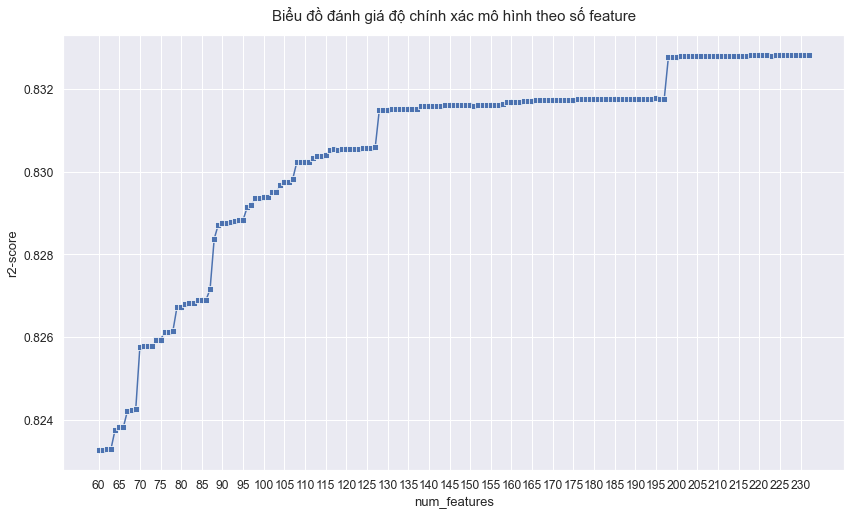

time: 500 ms


In [43]:
plt.figure(figsize=(14, 8));
sns.lineplot(x='num_features', y='r2score', data=survey_df, marker='s');
plt.xlabel('num_features', size=13)
plt.xticks(np.arange(survey_df['num_features'].min(), survey_df['num_features'].max()+1, step=5))
plt.ylabel('r2-score', size=13)
plt.title('Biểu đồ đánh giá độ chính xác mô hình theo số feature', size=15, y=1.02)
plt.grid(True)

- <span style="color:blue">Nhận xét:
    - Theo biểu đồ ta chọn số feature = 200, loại đi 33 feature

- Review 200 feature được chọn

In [44]:
X_train_ps, X_test_ps, feature_df = F_test_select(X_train_el, X_test_el, y_train, num_feats=200)
X_train_ps

,Kyori,TenkoBaba$DirtBabaCD_0,TenkoBaba$SibaBabaCD_0,TenkoBaba$SibaBabaCD_1,TenkoBaba$DirtBabaCD_1,id$RaceNum,TrackCD_52,TrackCD_17,JyokenInfo$SyubetuCD_18,GradeCD_,...,KS_ChokyosiCode_386.0,CH_Syotai_岩手,KS_Syotai_アメリカ,CH_Syotai_荒尾,KS_Syotai_フランス,KS_Syotai_川崎,KS_Syotai_笠松,id$JyoCD_1,KS_ChokyosiCode_365.0,CH_Syotai_川崎
0,-0.802876,0.0,1.0,0.0,0.0,-0.381357,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-1.045283,1.0,0.0,1.0,0.0,1.664316,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.893973,1.0,0.0,1.0,0.0,-0.673597,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.409159,0.0,1.0,0.0,1.0,-0.089118,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475191,0.409159,1.0,0.0,1.0,0.0,-0.381357,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
475192,0.409159,1.0,0.0,0.0,0.0,-0.381357,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
475193,0.893973,0.0,1.0,0.0,1.0,1.079838,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
475194,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


time: 1.64 s


In [45]:
feature_df

,feature,F-value,p_value
0,Kyori,248099.619124,0.000000
1,TenkoBaba$DirtBabaCD_0,158728.141292,0.000000
2,TenkoBaba$SibaBabaCD_0,95297.086635,0.000000
3,TenkoBaba$SibaBabaCD_1,92771.814378,0.000000
4,TenkoBaba$DirtBabaCD_1,78575.175655,0.000000
...,...,...,...
195,KS_Syotai_川崎,2.525465,0.112022
196,KS_Syotai_笠松,2.452840,0.117313
197,id$JyoCD_1,2.404195,0.121011
198,KS_ChokyosiCode_365.0,2.362726,0.124266


time: 156 ms


- Vẽ biểu đồ theo thứ tự độ quan trọng F- value

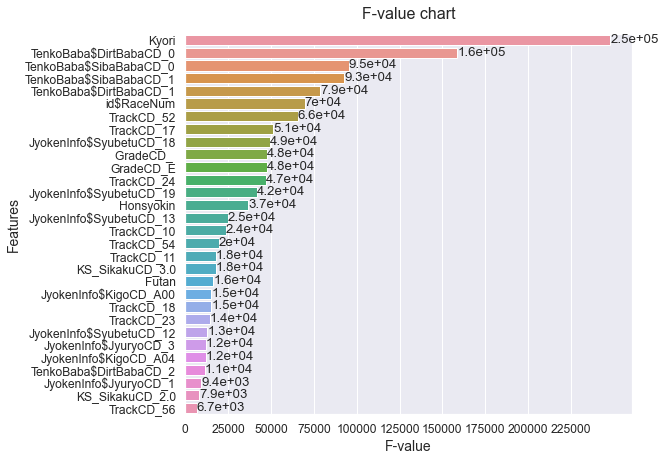

time: 969 ms


In [46]:
test_df = feature_df[:30]
sns.set(font_scale=1.1, style='darkgrid')
plt.figure(figsize=(8,7));
ax = sns.barplot(y=test_df.feature, x='F-value', data=test_df, orient='h');
plt.xlabel('F-value', size=14);
plt.ylabel('Features', size=14);
plt.xticks(np.arange(0, 2.5e5, step=2.5e4));
plt.title('F-value chart', pad=15, size=16)
for p, value in zip(ax.patches, test_df['F-value']):
    if value >=0:
        ax.text(p.get_width(), p.get_y()+0.6, '{0:.2g}'.format(value))
    else:
        ax.text(p.get_width()-0.09, p.get_y()+0.6, '{0:.2g}'.format(value))


- Danh sách feature rút gọn:

In [47]:
filter_feature = []
for feat in feature_df['feature']:
    inverse = feat[::-1]
    index = inverse.find('_')
    new_inverse = inverse[index+1:]
    new_feat = new_inverse[::-1]
    filter_feature.append(new_feat)
feature_df['filter_feature'] = filter_feature
new_feature_df = feature_df.drop_duplicates(subset=['filter_feature'], keep='first').reset_index(drop=True)
new_feature_df['feature'] = new_feature_df['filter_feature']
new_feature_df.drop('filter_feature', axis=1, inplace=True)
new_feature_df

,feature,F-value,p_value
0,Kyori,248099.619124,0.000000e+00
1,TenkoBaba$DirtBabaCD,158728.141292,0.000000e+00
2,TenkoBaba$SibaBabaCD,95297.086635,0.000000e+00
3,id$RaceNum,69755.812250,0.000000e+00
4,TrackCD,65612.424786,0.000000e+00
5,JyokenInfo$SyubetuCD,49289.924691,0.000000e+00
6,GradeCD,47700.759364,0.000000e+00
7,Honsyokin,36670.153395,0.000000e+00
8,KS_SikakuCD,17794.564153,0.000000e+00
9,Futan,16233.618320,0.000000e+00


time: 141 ms


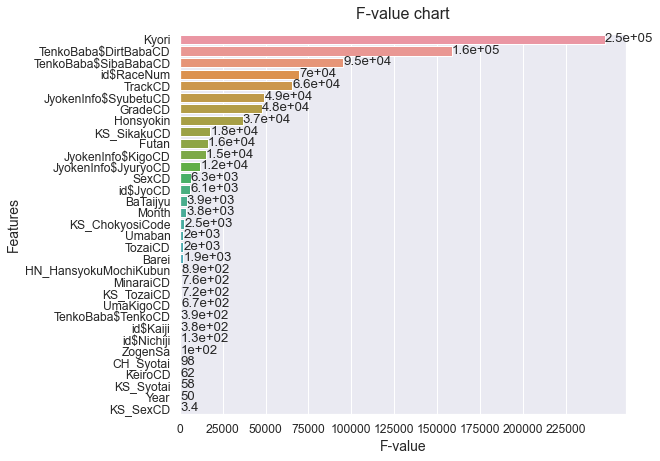

time: 969 ms


In [48]:
sns.set(font_scale=1.1, style='darkgrid')
plt.figure(figsize=(8,7));
ax = sns.barplot(y=new_feature_df['feature'], x='F-value', data=new_feature_df, orient='h');
plt.xlabel('F-value', size=14);
plt.ylabel('Features', size=14);
plt.xticks(np.arange(0, 2.5e5, step=2.5e4));
plt.title('F-value chart', pad=15, size=16)
for p, value in zip(ax.patches, new_feature_df['F-value']):
    if value >=0:
        ax.text(p.get_width(), p.get_y()+0.6, '{0:.2g}'.format(value))
    else:
        ax.text(p.get_width()-0.09, p.get_y()+0.6, '{0:.2g}'.format(value))


## 3. Tạo hàm chọn tự động feature

In [49]:
def _feature_selection(pre_process_data_df):
    
    id_col = ['race_id', 'KettoNum', 'id$Year']

    cat_col = [
                'Month',
                'id$JyoCD', # Mã trường đua
                'GradeCD',
                'JyokenInfo$SyubetuCD', # Cuộc đua dành cho ngựa bao nhiêu tuổi
                'JyokenInfo$KigoCD',
                'JyokenInfo$JyuryoCD', # Cách tính trọng lượng
                'TrackCD',
                'TenkoBaba$TenkoCD',
                'TenkoBaba$SibaBabaCD',
                'TenkoBaba$DirtBabaCD',
                'Umaban',
                'UmaKigoCD',
                'SexCD',
                'HinsyuCD',
                'KeiroCD',
                'TozaiCD',
                'MinaraiCD',
                'HN_HansyokuMochiKubun',
                # Xét sau
                'KS_SexCD',
                'KS_SikakuCD',
                'KS_TozaiCD',
                'KS_Syotai',
                'KS_ChokyosiCode',
                'CH_SexCD',
                'CH_TozaiCD',
                'CH_Syotai',
                ]

    num_col = [
                'id$Kaiji',
                'id$Nichiji',
                'id$RaceNum',
                #
                'Year',
                'Kyori',
                'Honsyokin',
                'Fukasyokin',
                'Barei',
                'Futan',
                'BaTaijyu',
                'ZogenSa',
               ]

    target_col = [
                    'Time',
                    'TimeDiff',
                    'speed',
                    'KakuteiJyuni',
                    'top3'
                 ]
    
    columns = id_col + cat_col + num_col + target_col
    offer_data = pre_process_data_df[columns]
    
    X_train, y_train_df, X_test, y_test_df, id_train, id_test, _, _ = transform_split_data(offer_data, id_col, cat_col, num_col, scale_data=True, target='speed',
                                                                                                                                       drop=None, shuffle=True, ref_col=None)
    y_train = y_train_df['speed']
    
    def corr_mutual_elimin(corr, elimin_threshold=0.9): 
        corr_threshold = elimin_threshold
        columns = np.full((corr.shape[0],), True, dtype=bool)
        for i in range(0, corr.shape[0]):
            for j in range(i+1, corr.shape[0]):
                if corr.iloc[i, j] >= corr_threshold:
                    if columns[j]:
                        columns[j] = False
        return columns

    corr = X_train.corr()
    columns_support = corr_mutual_elimin(corr, elimin_threshold=0.9)
    sl_feats_el = X_train.columns[columns_support]
    X_train_el = X_train[sl_feats_el]
    X_test_el = X_test[sl_feats_el]
    
    def F_test_select(X_train, X_test, y_train, num_feats=200):
        f_selector = SelectKBest(score_func=f_regression, k='all') 
        f_selector.fit_transform(X_train, y_train)
        f_support = f_selector.get_support()
        f_feature = X_train.iloc[:, f_support].columns.tolist()
        feature_df = pd.DataFrame({'feature': f_feature,
                                  'F-value': f_selector.scores_,
                                  'p_value': f_selector.pvalues_})
        feature_df.sort_values(by='F-value', ascending=False, inplace=True)
        feature_df.reset_index(drop=True, inplace=True)
        #feature_df = feature_df[feature_df['p_value']<=0.05]
        feature_df = feature_df.loc[:num_feats-1, :]
        selected_features = feature_df['feature']
        X_train_ps = X_train[selected_features]
        X_test_ps = X_test[selected_features]
        return X_train_ps, X_test_ps, feature_df
    
    X_train_ps, X_test_ps, feature_df = F_test_select(X_train_el, X_test_el, y_train, num_feats=200)
    
    filter_feature = []
    for feat in feature_df['feature']:
        inverse = feat[::-1]
        index = inverse.find('_')
        new_inverse = inverse[index+1:]
        new_feat = new_inverse[::-1]
        filter_feature.append(new_feat)
    feature_df['filter_feature'] = filter_feature
    new_feature_df = feature_df.drop_duplicates(subset=['filter_feature'], keep='first').reset_index(drop=True)
    new_feature_df['feature'] = new_feature_df['filter_feature']
    new_feature_df.drop('filter_feature', axis=1, inplace=True)
    
    selected_feature = new_feature_df['feature'].tolist()
    extract_feature = feature_df['feature'].tolist()
    print('Có tất cả {} feature được chọn'.format(len(selected_feature)))
    return X_train_ps, X_test_ps, y_train_df, y_test_df, id_train, id_test, selected_feature, extract_feature  

    

time: 157 ms


In [50]:
X_train_ps, X_test_ps, y_train_df, y_test_df, id_train, id_test, selected_feature, extract_feature = _feature_selection(data_df)
X_train_ps

Có tất cả 33 feature được chọn


,Kyori,TenkoBaba$DirtBabaCD_0,TenkoBaba$SibaBabaCD_0,TenkoBaba$SibaBabaCD_1,TenkoBaba$DirtBabaCD_1,id$RaceNum,TrackCD_52,TrackCD_17,JyokenInfo$SyubetuCD_18,GradeCD_,...,KS_ChokyosiCode_386.0,CH_Syotai_岩手,KS_Syotai_アメリカ,CH_Syotai_荒尾,KS_Syotai_フランス,KS_Syotai_川崎,KS_Syotai_笠松,id$JyoCD_1,KS_ChokyosiCode_365.0,CH_Syotai_川崎
0,-0.560469,1.0,0.0,1.0,0.0,1.372077,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.893973,1.0,0.0,0.0,0.0,-0.381357,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.893973,1.0,0.0,1.0,0.0,1.372077,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.409159,1.0,0.0,1.0,0.0,-1.550314,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.166752,0.0,1.0,0.0,1.0,0.787599,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475191,1.863602,0.0,1.0,0.0,1.0,0.787599,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
475192,0.166752,0.0,1.0,0.0,1.0,1.372077,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
475193,-1.530097,0.0,1.0,0.0,1.0,-0.089118,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
475194,-1.045283,0.0,1.0,0.0,1.0,0.495360,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


time: 1min 31s


In [51]:
y_train_df

,id$Year,race_id,KettoNum,speed,Time,KakuteiJyuni,top3
0,2015,25609,2010104751,62.260655,80.95,7,0
1,2010,7878,2007101609,58.017728,124.10,4,0
2,2011,13521,2008110046,59.825509,120.35,4,0
3,2008,2220,2006105746,59.449541,109.00,5,0
4,2016,29966,2010103540,56.666667,108.00,4,0
...,...,...,...,...,...,...,...
475191,2012,13877,2006106478,54.033771,159.90,12,0
475192,2011,12705,2007101829,57.357076,106.70,4,0
475193,2011,12294,2007100217,59.210526,60.80,7,0
475194,2012,16594,2009103509,59.056733,73.15,9,0


time: 141 ms


In [52]:
len(extract_feature)

200

time: 109 ms


In [53]:
len(selected_feature)

33

time: 125 ms


In [54]:
y_test_df

,id$Year,race_id,KettoNum,speed,Time,KakuteiJyuni,top3
0,2018,34535,2015101022,58.064516,74.4,10,0
1,2018,34535,2015103483,57.908847,74.6,11,0
2,2018,34535,2015106010,59.178082,73.0,2,1
3,2018,34535,2015102342,58.775510,73.5,6,0
4,2018,34535,2015102323,57.142857,75.6,16,0
...,...,...,...,...,...,...,...
19140,2018,35925,2014105425,58.378378,111.0,1,1
19141,2018,35925,2014105543,57.857143,112.0,5,0
19142,2018,35925,2011106130,57.754011,112.2,6,0
19143,2018,35925,2012102418,57.497782,112.7,8,0


time: 157 ms


## 4. Lưu dữ liệu sẵn sàng cho triển khai model

- Train data, test data, extract features, selected_feature
- Lưu dữ liệu bao gồm cả id_col

In [55]:
train_data = pd.concat([id_train, X_train_ps], axis=1, sort=False)
train_data['speed'] = y_train_df['speed']
train_data

,race_id,KettoNum,id$Year,Kyori,TenkoBaba$DirtBabaCD_0,TenkoBaba$SibaBabaCD_0,TenkoBaba$SibaBabaCD_1,TenkoBaba$DirtBabaCD_1,id$RaceNum,TrackCD_52,...,CH_Syotai_岩手,KS_Syotai_アメリカ,CH_Syotai_荒尾,KS_Syotai_フランス,KS_Syotai_川崎,KS_Syotai_笠松,id$JyoCD_1,KS_ChokyosiCode_365.0,CH_Syotai_川崎,speed
0,25609,2010104751,2015,-0.560469,1.0,0.0,1.0,0.0,1.372077,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.260655
1,7878,2007101609,2010,0.893973,1.0,0.0,0.0,0.0,-0.381357,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.017728
2,13521,2008110046,2011,0.893973,1.0,0.0,1.0,0.0,1.372077,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.825509
3,2220,2006105746,2008,0.409159,1.0,0.0,1.0,0.0,-1.550314,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.449541
4,29966,2010103540,2016,0.166752,0.0,1.0,0.0,1.0,0.787599,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,56.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475191,13877,2006106478,2012,1.863602,0.0,1.0,0.0,1.0,0.787599,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.033771
475192,12705,2007101829,2011,0.166752,0.0,1.0,0.0,1.0,1.372077,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,57.357076
475193,12294,2007100217,2011,-1.530097,0.0,1.0,0.0,1.0,-0.089118,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.210526
475194,16594,2009103509,2012,-1.045283,0.0,1.0,0.0,1.0,0.495360,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.056733


time: 500 ms


In [56]:
test_data = pd.concat([id_test, X_test_ps], axis=1, sort=False)
test_data['speed'] = y_test_df['speed']
test_data

,race_id,KettoNum,id$Year,Kyori,TenkoBaba$DirtBabaCD_0,TenkoBaba$SibaBabaCD_0,TenkoBaba$SibaBabaCD_1,TenkoBaba$DirtBabaCD_1,id$RaceNum,TrackCD_52,...,CH_Syotai_岩手,KS_Syotai_アメリカ,CH_Syotai_荒尾,KS_Syotai_フランス,KS_Syotai_川崎,KS_Syotai_笠松,id$JyoCD_1,KS_ChokyosiCode_365.0,CH_Syotai_川崎,speed
0,34535,2015101022,2018,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.064516
1,34535,2015103483,2018,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.908847
2,34535,2015106010,2018,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.178082
3,34535,2015102342,2018,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.775510
4,34535,2015102323,2018,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19140,35925,2014105425,2018,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.378378
19141,35925,2014105543,2018,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.857143
19142,35925,2011106130,2018,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.754011
19143,35925,2012102418,2018,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.497782


time: 172 ms


In [57]:
y_train_df.to_csv('y_train_df.csv', index=False)

time: 2.41 s


In [58]:
y_test_df.to_csv('y_test_df.csv', index=False)

time: 203 ms


In [59]:
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

time: 1min 14s


In [60]:
y_train_df = pd.read_csv('y_train_df.csv')
y_train_df

,id$Year,race_id,KettoNum,speed,Time,KakuteiJyuni,top3
0,2015,25609,2010104751,62.260655,80.95,7,0
1,2010,7878,2007101609,58.017728,124.10,4,0
2,2011,13521,2008110046,59.825509,120.35,4,0
3,2008,2220,2006105746,59.449541,109.00,5,0
4,2016,29966,2010103540,56.666667,108.00,4,0
...,...,...,...,...,...,...,...
475191,2012,13877,2006106478,54.033771,159.90,12,0
475192,2011,12705,2007101829,57.357076,106.70,4,0
475193,2011,12294,2007100217,59.210526,60.80,7,0
475194,2012,16594,2009103509,59.056733,73.15,9,0


time: 453 ms


In [61]:
feature_dict = {}
feature_dict['selected_feature'] = selected_feature
feature_dict['extract_feature'] = extract_feature
feature_dict['cat_col'] = cat_col
feature_dict['num_col'] = num_col
feature_dict

{'selected_feature': ['Kyori',
  'TenkoBaba$DirtBabaCD',
  'TenkoBaba$SibaBabaCD',
  'id$RaceNum',
  'TrackCD',
  'JyokenInfo$SyubetuCD',
  'GradeCD',
  'Honsyokin',
  'KS_SikakuCD',
  'Futan',
  'JyokenInfo$KigoCD',
  'JyokenInfo$JyuryoCD',
  'SexCD',
  'id$JyoCD',
  'BaTaijyu',
  'Month',
  'KS_ChokyosiCode',
  'Umaban',
  'TozaiCD',
  'Barei',
  'HN_HansyokuMochiKubun',
  'MinaraiCD',
  'KS_TozaiCD',
  'UmaKigoCD',
  'TenkoBaba$TenkoCD',
  'id$Kaiji',
  'id$Nichiji',
  'ZogenSa',
  'CH_Syotai',
  'KeiroCD',
  'KS_Syotai',
  'Year',
  'KS_SexCD'],
 'extract_feature': ['Kyori',
  'TenkoBaba$DirtBabaCD_0',
  'TenkoBaba$SibaBabaCD_0',
  'TenkoBaba$SibaBabaCD_1',
  'TenkoBaba$DirtBabaCD_1',
  'id$RaceNum',
  'TrackCD_52',
  'TrackCD_17',
  'JyokenInfo$SyubetuCD_18',
  'GradeCD_ ',
  'GradeCD_E',
  'TrackCD_24',
  'JyokenInfo$SyubetuCD_19',
  'Honsyokin',
  'JyokenInfo$SyubetuCD_13',
  'TrackCD_10',
  'TrackCD_54',
  'TrackCD_11',
  'KS_SikakuCD_3.0',
  'Futan',
  'JyokenInfo$KigoCD_A00',

time: 125 ms


In [62]:
import json
with open('feature_dict.json', 'w') as js:
    json.dump(feature_dict, js)


time: 125 ms


In [63]:
with open('feature_dict.json') as js:
    d = json.load(js)
new_col = d['extract_feature']

time: 125 ms


In [64]:
ttt = train_data[new_col]
ttt

,Kyori,TenkoBaba$DirtBabaCD_0,TenkoBaba$SibaBabaCD_0,TenkoBaba$SibaBabaCD_1,TenkoBaba$DirtBabaCD_1,id$RaceNum,TrackCD_52,TrackCD_17,JyokenInfo$SyubetuCD_18,GradeCD_,...,KS_ChokyosiCode_386.0,CH_Syotai_岩手,KS_Syotai_アメリカ,CH_Syotai_荒尾,KS_Syotai_フランス,KS_Syotai_川崎,KS_Syotai_笠松,id$JyoCD_1,KS_ChokyosiCode_365.0,CH_Syotai_川崎
0,-0.560469,1.0,0.0,1.0,0.0,1.372077,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.893973,1.0,0.0,0.0,0.0,-0.381357,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.893973,1.0,0.0,1.0,0.0,1.372077,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.409159,1.0,0.0,1.0,0.0,-1.550314,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.166752,0.0,1.0,0.0,1.0,0.787599,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475191,1.863602,0.0,1.0,0.0,1.0,0.787599,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
475192,0.166752,0.0,1.0,0.0,1.0,1.372077,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
475193,-1.530097,0.0,1.0,0.0,1.0,-0.089118,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
475194,-1.045283,0.0,1.0,0.0,1.0,0.495360,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


time: 844 ms
